In [20]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.model_selection import train_test_split
import umap.umap_ as umap 
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.decomposition import FastICA



In [35]:
path = "data/"

data=pd.read_csv(path+'A2_data.csv')
X,y= data.loc[:, data.columns != 'class'], data['class']

print(f'There are {X.shape[0]} samples of each {X.shape[1]} features')

#Data includes some identifiers lets remove those 
ID_parameters= ['field_ID','MJD','plate', 'alpha', 'delta']
for ID in ID_parameters:
    X=X.loc[:, X.columns != ID]

#We know that a flux should be positive so remove the datapoint which does not have that
#This datapoint has value -9999 so not a detection but a instrumentation issue
I_remove=np.where(X['u']<0)[0]
X,y = X.drop(I_remove),y.drop(I_remove)
X,y=X.reset_index(drop=True),y.reset_index(drop=True)

print(f'There are final {X.shape[0]} samples of now {X.shape[1]} features')

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.33, random_state=42)

print(f'There are {X_train.shape[0]} training samples of each {X_train.shape[1]} features')

There are 100000 samples of each 11 features
There are final 99999 samples of now 6 features
There are 66999 training samples of each 6 features


In [26]:
np.where(np.isnan(X_train))

(array([], dtype=int64), array([], dtype=int64))

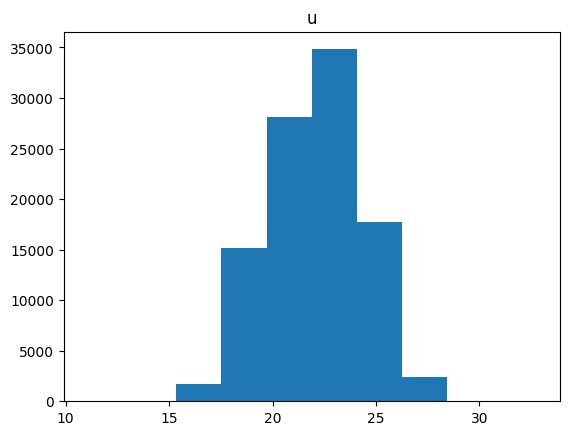

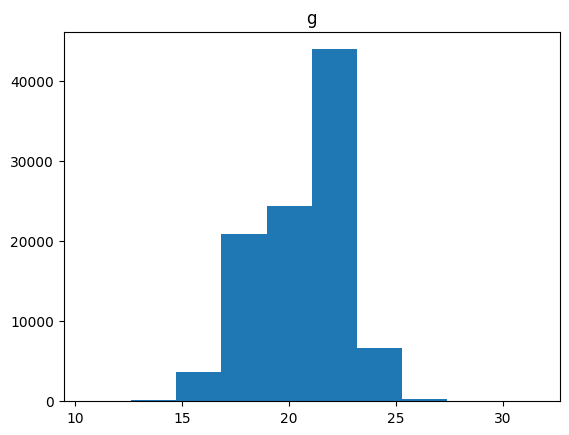

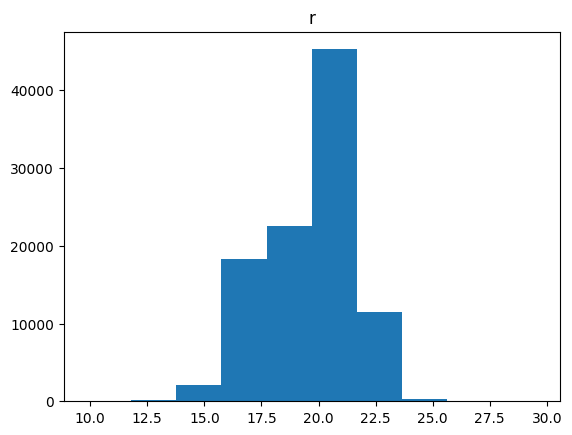

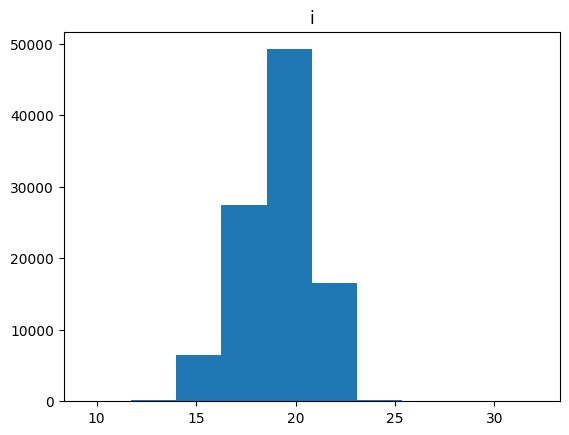

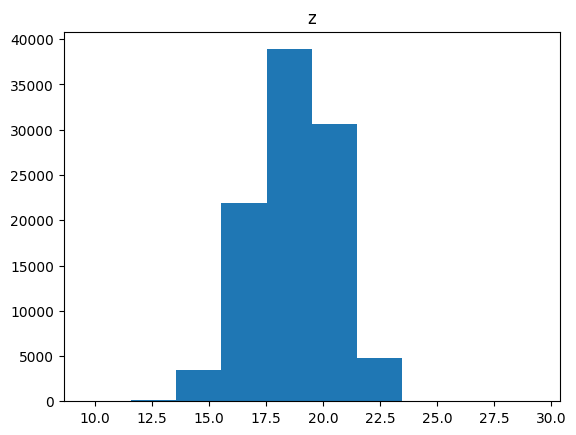

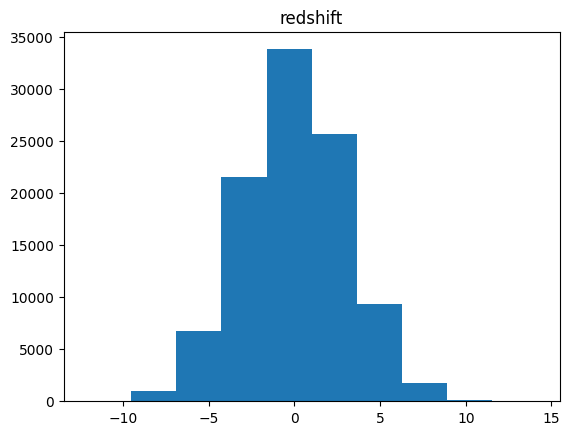

In [36]:
for C in X.columns:
    plt.hist(X[C])
    plt.title(C)
    plt.show()

In [37]:
#Visualise the models
def visualise_components(model_name, y, finaldim):
    fig = plt.figure(figsize = (8,8))
    ax = fig.add_subplot(1,1,1) 
    ax.set_xlabel('Component 1', fontsize = 15)
    ax.set_ylabel('Component 2', fontsize = 15)
    ax.set_title(f'2 component {model_name}', fontsize = 20)
    targets = np.unique(y)
    colors = ['r', 'g', 'b','k','y']
    for target, color in zip(targets,colors):
        indicesToKeep = finaldim['class'] == target
        ax.scatter(finaldim.loc[indicesToKeep, 'component 1']
                , finaldim.loc[indicesToKeep, 'component 2']
                , c = color
                , s = 50
                , marker = '.')
    ax.legend(targets, fontsize=15)
    ax.grid()
    plt.savefig(f'plots/{model_name}.pdf')
    plt.show()

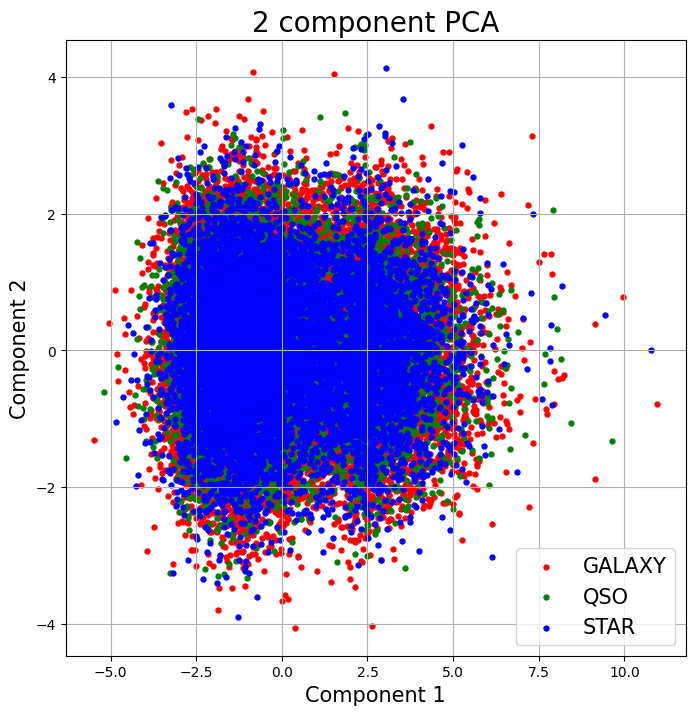

In [38]:
x = X_train
x = StandardScaler().fit_transform(x)


# Use PCA to reduce to two dimensions
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principal = pd.DataFrame(data = principalComponents,columns = ['component 1', 'component 2'])
finalPca = pd.concat([principal, y_train], axis = 1)
finalPca

visualise_components('PCA', y_train, finalPca)


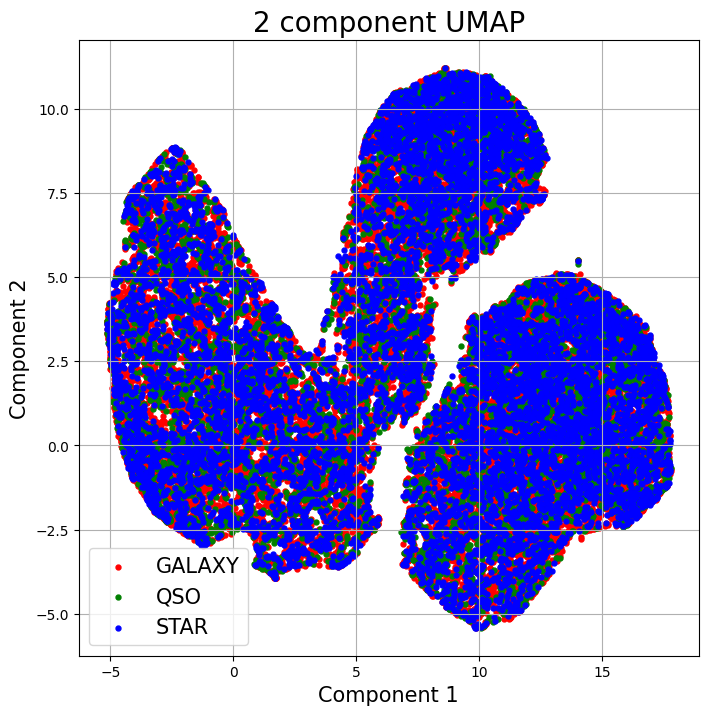

In [39]:
reducer = umap.UMAP()
UmapComponents = reducer.fit_transform(x)
UmapDf = pd.DataFrame(data = UmapComponents,columns = ['component 1', 'component 2'])
finalUmapDf = pd.concat([UmapDf, y_train], axis = 1)
finalUmapDf

visualise_components('UMAP', y_train, finalUmapDf)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 66999 samples in 0.059s...
[t-SNE] Computed neighbors for 66999 samples in 5.814s...
[t-SNE] Computed conditional probabilities for sample 1000 / 66999
[t-SNE] Computed conditional probabilities for sample 2000 / 66999
[t-SNE] Computed conditional probabilities for sample 3000 / 66999
[t-SNE] Computed conditional probabilities for sample 4000 / 66999
[t-SNE] Computed conditional probabilities for sample 5000 / 66999
[t-SNE] Computed conditional probabilities for sample 6000 / 66999
[t-SNE] Computed conditional probabilities for sample 7000 / 66999
[t-SNE] Computed conditional probabilities for sample 8000 / 66999
[t-SNE] Computed conditional probabilities for sample 9000 / 66999
[t-SNE] Computed conditional probabilities for sample 10000 / 66999
[t-SNE] Computed conditional probabilities for sample 11000 / 66999
[t-SNE] Computed conditional probabilities for sample 12000 / 66999
[t-SNE] Computed conditional probabilities for sam

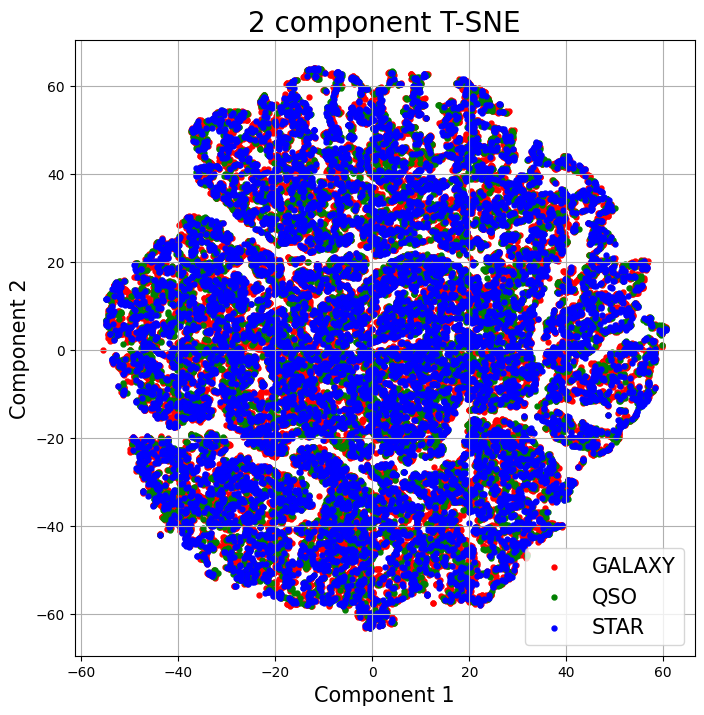

In [40]:
# Use T-SNE to reduce to two dimensions
tsne = TSNE(n_components=2, verbose=1)
tsneComponents = tsne.fit_transform(x)
tsneDf = pd.DataFrame(data = tsneComponents,columns = ['component 1', 'component 2'])
finalTsneDf = pd.concat([tsneDf, y_train], axis = 1)
finalTsneDf

visualise_components('T-SNE', y_train, finalTsneDf)

In [41]:
#Try ICA

transformer = FastICA(n_components=2,whiten='unit-variance')
icacomponents = transformer.fit_transform(x)
icaDf= pd.DataFrame(data = icacomponents,columns = ['component 1', 'component 2'])
icaDf = pd.concat([icaDf, y_train], axis = 1)
icaDf

#visualise_components('ICA', y_train, icaDf)

,component 1,component 2,class
0,0.000480,-0.000006,GALAXY
1,0.000010,-0.008236,GALAXY
2,0.002288,0.001626,GALAXY
3,0.005974,0.004149,GALAXY
4,0.002052,-0.001564,GALAXY
...,...,...,...
99988,NaN,NaN,GALAXY
99989,NaN,NaN,GALAXY
99994,NaN,NaN,GALAXY
99996,NaN,NaN,GALAXY


In [45]:
print(np.shape(np.where((finalPca).isnull())))
print(np.shape(np.where((finalUmapDf).isnull())))
print(np.shape(np.where((finalTsneDf).isnull())))
if np.where((finalPca).isnull()).all() == np.where((finalUmapDf).isnull()).all():
    print('yes')
#if np.where((finalPca).isnull()) == np.where((finalTsneDf).isnull()):
#    print('yes2')

print(np.shape(np.where((icaDf).isnull())))


(2, 66447)
(2, 66447)
(2, 66447)


AttributeError: 'tuple' object has no attribute 'all'

3


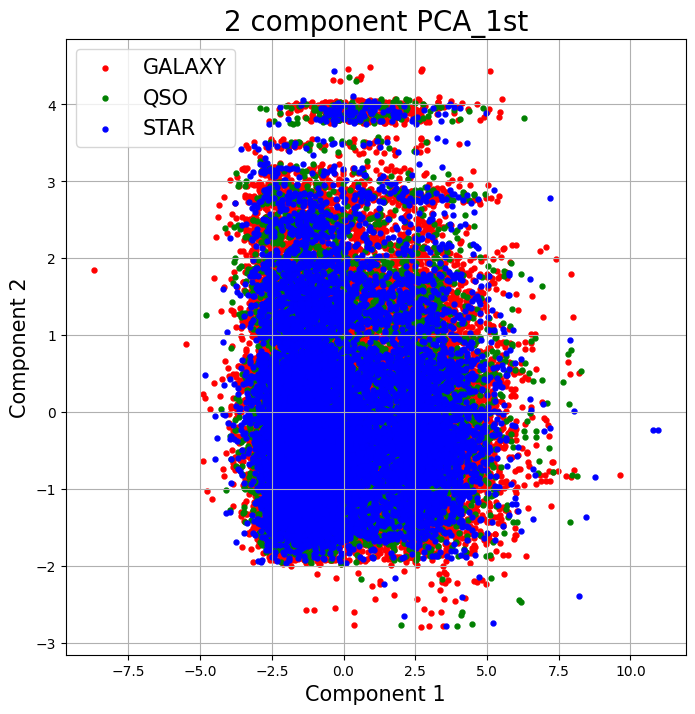

3


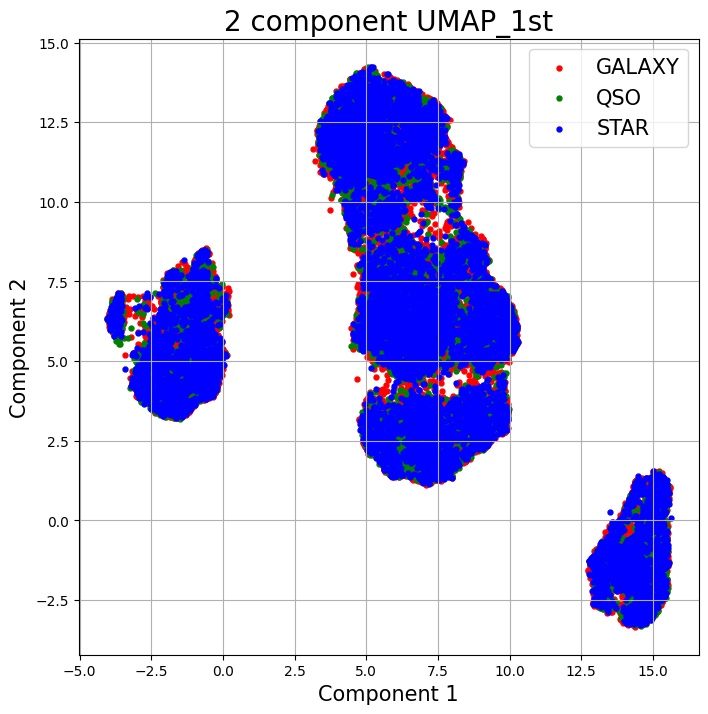

3


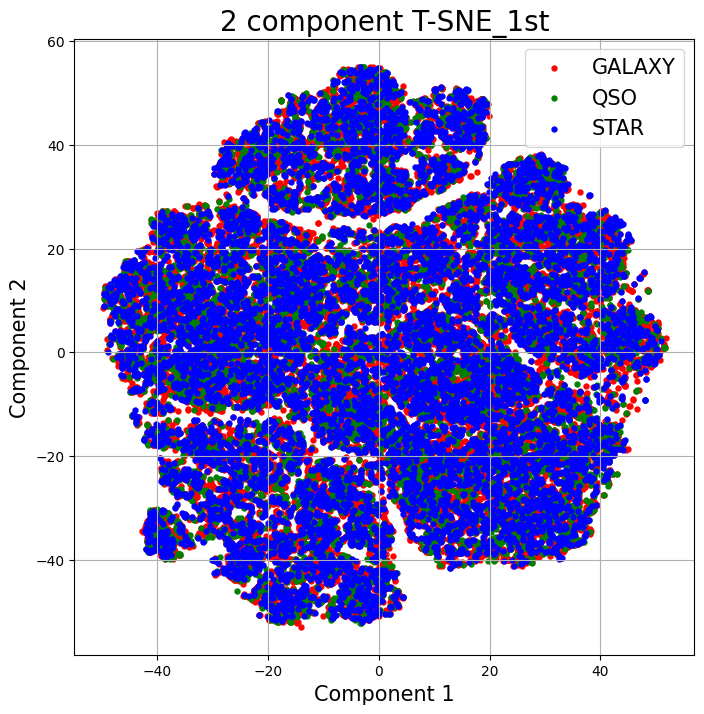

In [33]:
visualise_components('PCA_1st', y_train, finalPca)
visualise_components('UMAP_1st', y_train, finalUmapDf)
visualise_components('T-SNE_1st', y_train, finalTsneDf)